# Hidden Markov Model



Tal cual como redes Bayesianas con probabilidades discretas, también es posible estudiar secuencias temporales discretas. Estas secuencias se dan en muchas problemas en que necesitamos clasificar el estado de un proceso (oculto o latente) $Z$ que toma valores (discretos o contínuos) a los que tenemos acceso a través de  variables observadas $X$.  


Sin embargo, si sabemos que el proceso $Z$ tiene la propiedad de Markov de primer orden $p(z_k \vert z_{k-1},\ldots,z_1)=p(z_k \vert z_{k-1})$ y que las observaciones $X$ son independientes entre si y solamente dependen de la variable oculta.

Las variables observadas pueden ser variables discretas o continuas. Cuando se consideran v.a. discretas, podemos especificar una matriz $\boldsymbol{A}_{[N \times N]}$ de transición para los $N$ posibles estados, una matriz de emisión $\boldsymbol{B}_{[M \times N]}$ y un conjunto de probabilidades iniciales $\boldsymbol{\pi}$.

$
\begin{align*}
\boldsymbol{A}_{n,n} =
\begin{pmatrix}
z_{1,1} & z_{1,2} & \cdots & z_{1,N} \\
z_{2,1} & z_{2,2} & \cdots & z_{2,N} \\
\vdots  & \vdots  & \ddots & \vdots  \\
z_{N,1} & z_{N,2} & \cdots & z_{N,N}
\end{pmatrix};\quad
&\boldsymbol{B}_{m,n} =
\begin{pmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,N} \\
x_{2,1} & x_{2,2} & \cdots & x_{2,N} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{M,1} & x_{M,2} & \cdots & x_{M,N}
\end{pmatrix}; \quad
\boldsymbol{\pi}=[\pi_1,\ldots,\pi_N]
\end{align*}
$

Dado un modelo $\lambda=(\boldsymbol{A,B,\pi})$, una secuencia observada $X_n=\{x_1,\ldots,x_n\}$ y un conjunto de estados $Z_n=\{z_1,\ldots,z_n\}$, los patrones de inferencia para HMM son los siguientes:

Filtrado : Determinar $p(z_n \vert X_n)$.

Verosimilitud :  Determinar $p(X_n)$.

Secuencia más probable :  $p(Z_n \vert X_n)$.

# Human Activity Recognition

En este laboratorio usaremos registro de actividades capturado por smartphones que fueron desarrolladas por 30 personas distintas. Entre las actividades se incluyen:

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING

Al mismo tiempo, cada registro de la base de datos incluye las siguientes mediciones:ç

Aceleracion total y aceleracion del cuerpo estimada en los 3 ejes (X-Y-Z)
Velocidad angular del giroscopio en 3 los ejes (X-Y-Z)
Un vector de dimensionalidad 561 con descriptores derivados a partir de los datos de movimiento.
Etiqueta de actividad
Un identificador de la persona que ejecuta la actividad
Los datos originales se pueden encontrar en este enlace

Más información del dataset se encuentra en:

Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False


print('Google Colab? ',IS_COLAB)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Google Colab?  True


In [2]:
if IS_COLAB:
    ! wget  -c "https://ucmcl-my.sharepoint.com/:u:/g/personal/shernandez_ucm_cl/EWvE2qLEt7lGkusfUcjYHnMBbtVOqIrdzY15Dnd2hHDUJA?e=NAeghv&download=1" -O HAR.tar.xz
    ! tar -xf HAR.tar.xz

--2024-10-22 15:34:50--  https://ucmcl-my.sharepoint.com/:u:/g/personal/shernandez_ucm_cl/EWvE2qLEt7lGkusfUcjYHnMBbtVOqIrdzY15Dnd2hHDUJA?e=NAeghv&download=1
Resolving ucmcl-my.sharepoint.com (ucmcl-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to ucmcl-my.sharepoint.com (ucmcl-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/shernandez_ucm_cl/Documents/HAR.tar.xz?ga=1 [following]
--2024-10-22 15:34:53--  https://ucmcl-my.sharepoint.com/personal/shernandez_ucm_cl/Documents/HAR.tar.xz?ga=1
Reusing existing connection to ucmcl-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 33237852 (32M) [application/octet-stream]
Saving to: ‘HAR.tar.xz’

HAR.tar.xz          100%[===================>]  31.70M  6.83MB/s    in 6.0s    

2024-10-22 15:35:00 (5.31 MB/s) - ‘HAR.tar.xz’ saved [33237852/33237852]



In [3]:
! ls HAR

x_test.npy  x_train.npy  y_test.npy  y_train.npy


In [4]:
import numpy as np

X_train=np.load('HAR/x_train.npy')
X_test=np.load('HAR/x_test.npy')
y_train=np.load('HAR/y_train.npy')
y_test=np.load('HAR/y_test.npy')

label_to_activity = {1: 'walking horizontally', 2: 'walking upstairs', 3: 'walking downstairs',
                     4: 'sitting', 5: 'standing', 6: 'laying'}

In [5]:
y_train.shape

(7352, 1)

In [6]:
y_train

array([[5],
       [5],
       [5],
       ...,
       [2],
       [2],
       [2]])

In [7]:
X_train.shape

(7352, 128, 9)

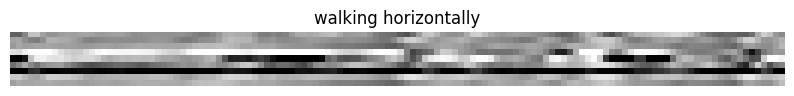

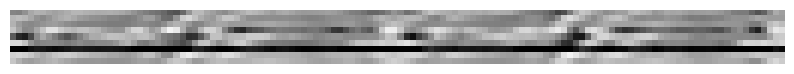

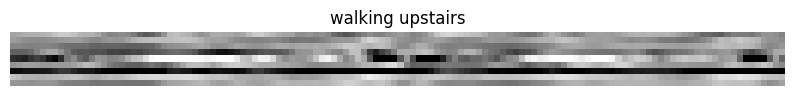

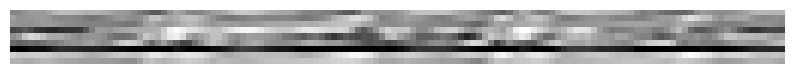

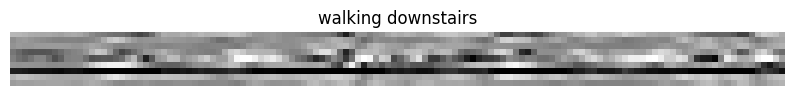

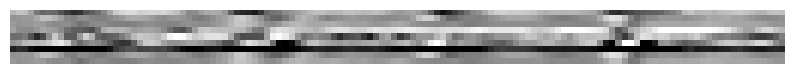

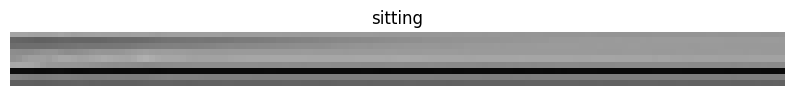

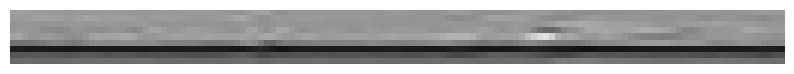

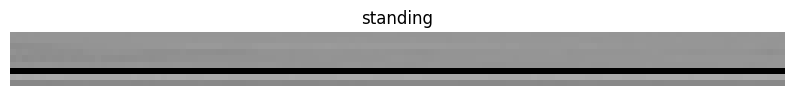

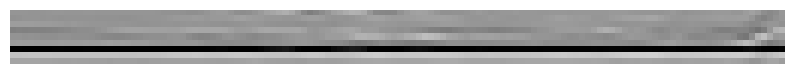

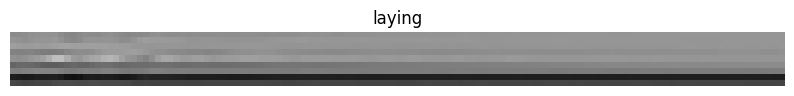

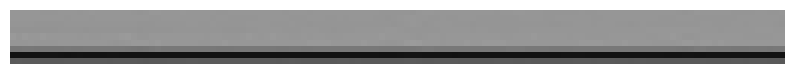

In [8]:
import matplotlib.pyplot as plt

def make_plots(num_examples_per_category):
    for label in range(1,7):
        x_label = X_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()

make_plots(2)

In [9]:
!pip install hmmlearn
!pip install dynamax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [10]:
X_activity=X_train[(y_train==1).flatten()]

In [11]:
X_activity.shape

(1226, 128, 9)

In [12]:
lengths=[X_activity.shape[1]]*X_activity.shape[0]

In [13]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=5, covariance_type="diag", n_iter=100)

In [14]:
model.fit(X_activity.reshape([X_activity.shape[0]*X_activity.shape[1],X_activity.shape[2]]),lengths)

GaussianHMM(n_components=5, n_iter=100)

Text(0, 0.5, 'Observation ')

<Figure size 1000x100 with 0 Axes>

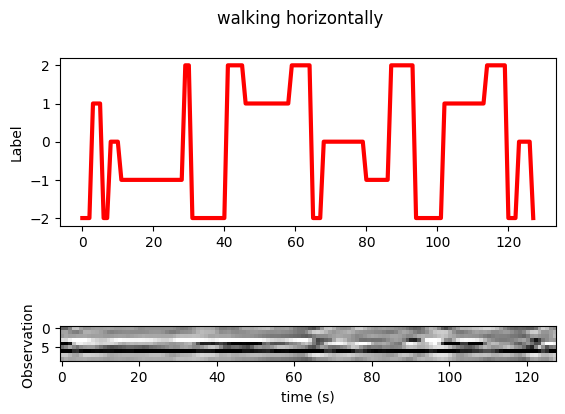

In [15]:
Z=model.predict(X_activity[0])
label=y_train[(y_train==1)][0]
plt.figure(figsize=(10, 1))
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle(label_to_activity[label])

ax1.plot(range(128),(Z-2),color="r",linewidth=3)
ax1.set_ylabel('Label')

ax2.imshow(X_activity[0].T, cmap='Greys', vmin=-1, vmax=1)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Observation ')



In [21]:
model_activities={activity:hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
                    for activity in label_to_activity.keys()}

In [22]:
model_activities

{1: GaussianHMM(n_components=3, n_iter=100),
 2: GaussianHMM(n_components=3, n_iter=100),
 3: GaussianHMM(n_components=3, n_iter=100),
 4: GaussianHMM(n_components=3, n_iter=100),
 5: GaussianHMM(n_components=3, n_iter=100),
 6: GaussianHMM(n_components=3, n_iter=100)}

In [23]:
for id,model in model_activities.items():
  X_activity=X_train[(y_train==id).flatten()]
  lengths=[X_activity.shape[1]]*X_activity.shape[0]
  model.fit(X_activity.reshape([X_activity.shape[0]*X_activity.shape[1],X_activity.shape[2]]),lengths)

In [24]:
y_hat=[]
for id_example in range(X_test.shape[0]):
  predicted_label_arr=[]
  for id,model in model_activities.items():
    predicted_label_arr.append(model.score(X_test[id_example]))
  predicted_label=np.array(predicted_label_arr).argmax()+1
  y_hat.append(predicted_label)


In [25]:
y_test.shape

(2947, 1)

In [26]:
np.array(y_hat).shape

(2947,)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test.reshape(-1)),np.int32(y_hat),target_names=label_to_activity.values()))

                      precision    recall  f1-score   support

walking horizontally       0.66      0.85      0.74       496
    walking upstairs       0.94      0.58      0.71       471
  walking downstairs       0.72      0.82      0.77       420
             sitting       0.93      0.74      0.82       491
            standing       0.81      0.92      0.86       532
              laying       1.00      1.00      1.00       537

            accuracy                           0.82      2947
           macro avg       0.84      0.82      0.82      2947
        weighted avg       0.85      0.82      0.82      2947



In [28]:
X_test.shape

(2947, 128, 9)

# Dynamax

In [29]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap

from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

In [30]:
true_num_states = 3
emission_dim = 9
hmm = DiagonalGaussianHMM(true_num_states, emission_dim)

In [31]:
def print_params(params):
    jnp.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    print("initial probs:")
    print(params.initial.probs.shape)
    print("transition matrix:")
    print(params.transitions.transition_matrix.shape)
    print("emission means:")
    print(params.emissions.means.shape) # since num_emissions = 1

key = jr.PRNGKey(0)
fbgd_params, fbgd_props = hmm.initialize(key)

print("Randomly initialized parameters")
print_params(fbgd_params)

Randomly initialized parameters
initial probs:
(3,)
transition matrix:
(3, 3)
emission means:
(3, 9)


In [32]:
batch_emissions=jnp.array(X_train[(y_train==1).flatten()])
num_batches=1226


em_key, key = jr.split(key)
em_params, em_param_props = hmm.initialize(em_key)
em_params, log_probs = hmm.fit_em(em_params,
                                  em_param_props,
                                  batch_emissions,
                                  num_iters=400)

<ipython-input-33-d349942e6bfa>:3: RuntimeWarning: invalid value encountered in log
  plt.plot(-1.0*np.log(log_probs[1:]))


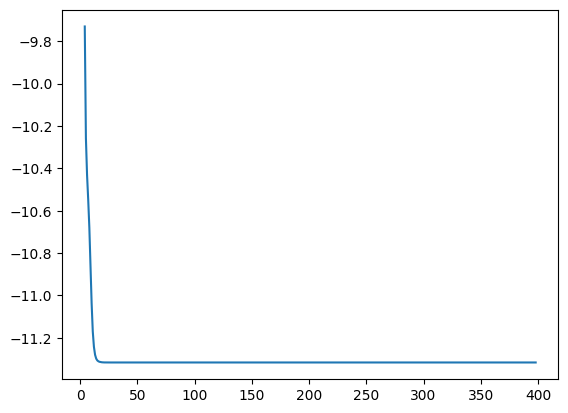

In [33]:
import matplotlib.pyplot as plt

plt.plot(-1.0*np.log(log_probs[1:]))

In [34]:
import jax

jax.vmap(hmm.marginal_log_prob,(None,0))(fbgd_params,batch_emissions).sum()

Array(-5910314496.000, dtype=float32)

In [35]:
jax.vmap(hmm.marginal_log_prob,(None,0))(em_params,batch_emissions).sum()

Array(82308.953, dtype=float32)

Si obervamos el logaritmo de la verosimilitud del modelo entrenado con una actividad, el modelo logra maximizar la verosimilitud de observar los datos. Ahora entrenamos las 6 actividades en paralelo

In [36]:
X_stack=[jnp.array(X_train[(y_train==i).flatten()]) for i in range(1,7)]

En cada actividad tenemos un número distinto de ejemplos de entrenamiento, por lo tanto usamos padding para 'rellenar' con ejemplos ficticios y de esa manera formar un único tensor de entrenamiento

In [37]:
[x.shape for x in X_stack]

[(1226, 128, 9),
 (1073, 128, 9),
 (986, 128, 9),
 (1286, 128, 9),
 (1374, 128, 9),
 (1407, 128, 9)]

In [38]:
max_num_examples=np.max(np.array([x.shape[0] for x in X_stack]))

In [39]:
max_num_examples

1407

In [40]:
X_stack[0].shape

(1226, 128, 9)

In [41]:
X_stack_expanded=[jnp.pad(X_stack[i],((0,max_num_examples-X_stack[i].shape[0]),(0,0),(0,0)),'edge') for i in range(len(X_stack))]

In [42]:
[x.shape for x in X_stack_expanded]

[(1407, 128, 9),
 (1407, 128, 9),
 (1407, 128, 9),
 (1407, 128, 9),
 (1407, 128, 9),
 (1407, 128, 9)]

In [43]:
X_stack_expanded=jnp.stack(X_stack_expanded)

Ahora inicializamos el modelo para recibir datos desde las 6 actividades.

In [44]:
import jax

em_key, key = jr.split(key)
key_tasks=jr.split(em_key,6)

em_params_tasks,em_param_props_tasks = jax.vmap(hmm.initialize, (0))(key_tasks)

In [45]:
print("Randomly initialized parameters")
print_params(em_params_tasks)

Randomly initialized parameters
initial probs:
(6, 3)
transition matrix:
(6, 3, 3)
emission means:
(6, 3, 9)


In [46]:
em_params_tasks, log_probs = jax.vmap(partial(hmm.fit_em,num_iters=100))(
                                  em_params_tasks,
                                  em_param_props_tasks,
                                  X_stack_expanded)

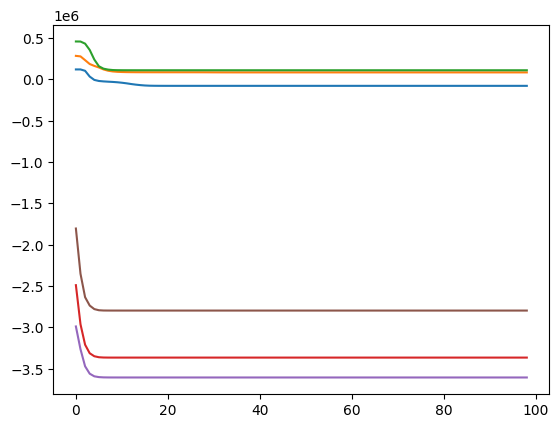

In [47]:
for i in range(6):
  plt.plot((-1.0*log_probs[i,1:]))

Text(0, 0.5, 'Observation ')

<Figure size 1000x100 with 0 Axes>

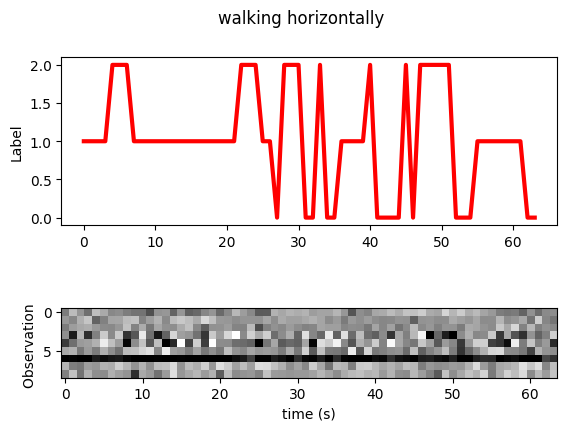

In [48]:
time_steps=64
true_states, emissions = jax.vmap(hmm.sample, (0,0,None))(em_params_tasks,key_tasks,time_steps)
plt.figure(figsize=(10, 1))
fig, (ax1, ax2) = plt.subplots(2,1)

label=1
fig.suptitle(label_to_activity[label])

ax1.plot(range(time_steps),true_states[label-1,:],color="r",linewidth=3)
ax1.set_ylabel('Label')

ax2.imshow(emissions[label-1,:].T, cmap='Greys', vmin=-1, vmax=1)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Observation ')

Text(0, 0.5, 'Observation ')

<Figure size 1000x100 with 0 Axes>

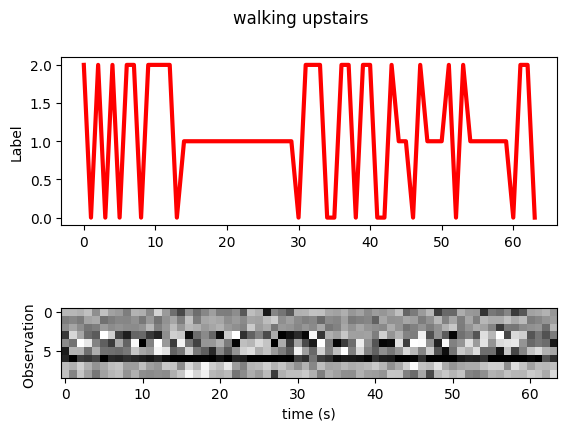

In [49]:
plt.figure(figsize=(10, 1))
fig, (ax1, ax2) = plt.subplots(2,1)

label=2
fig.suptitle(label_to_activity[label])

ax1.plot(range(time_steps),true_states[label-1,:],color="r",linewidth=3)
ax1.set_ylabel('Label')

ax2.imshow(emissions[label-1,:].T, cmap='Greys', vmin=-1, vmax=1)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Observation ')

Text(0, 0.5, 'Observation ')

<Figure size 1000x100 with 0 Axes>

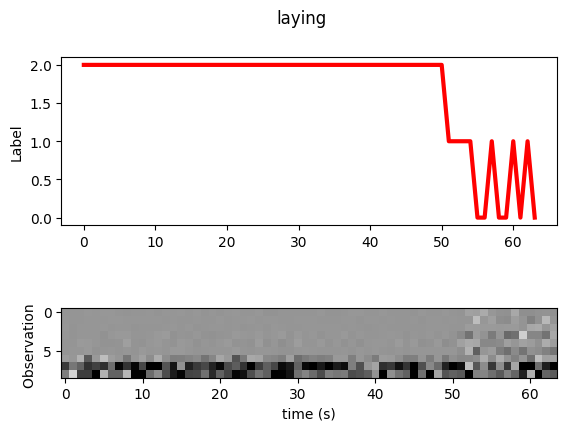

In [50]:
plt.figure(figsize=(10, 1))
fig, (ax1, ax2) = plt.subplots(2,1)

label=6
fig.suptitle(label_to_activity[label])

ax1.plot(range(time_steps),true_states[label-1,:],color="r",linewidth=3)
ax1.set_ylabel('Label')

ax2.imshow(emissions[label-1,:].T, cmap='Greys', vmin=-1, vmax=1)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Observation ')

In [51]:
treedef = jax.tree_util.tree_structure(em_params)
y_log_prob=list()
for i in range(6):
  vals_tree = jax.tree_util.tree_unflatten(treedef, [theta[i,:] for theta in jax.tree_util.tree_leaves(em_params_tasks)])
  y_log_prob.append(jax.vmap(hmm.marginal_log_prob,(None,0))(vals_tree,X_test))

In [52]:
y_log_prob=jnp.stack(y_log_prob)

In [53]:
y_hat=jnp.argmax(y_log_prob,axis=0)+1

In [54]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test.reshape(-1)),np.int32(y_hat),target_names=label_to_activity.values()))

                      precision    recall  f1-score   support

walking horizontally       0.58      0.84      0.69       496
    walking upstairs       0.78      0.56      0.65       471
  walking downstairs       0.79      0.66      0.72       420
             sitting       0.94      0.61      0.74       491
            standing       0.74      0.94      0.83       532
              laying       1.00      1.00      1.00       537

            accuracy                           0.78      2947
           macro avg       0.80      0.77      0.77      2947
        weighted avg       0.81      0.78      0.78      2947

